In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mappings import map_country_id_to_country_name, map_country_name_to_country_id, map_month_id_to_datetime, map_date_to_month_id

In [2]:
model_identifier = 'model3_zinb_feature_set1'
pps = pd.read_parquet(fr'C:\Users\Uwe Drauz\Documents\bachelor_thesis_local\personal_competition_data\Results\{model_identifier}_posterior_predicitve_samples.parquet')

In [9]:
# Shaded quantile bands
def plot_country_data(df, country_name, year_start, month_start, year_end, month_end):
    # Assume the map_date_to_month_id and map_country_name_to_country_id functions are defined elsewhere
    month_id_start = map_date_to_month_id(year_start, month_start)
    month_id_end = map_date_to_month_id(year_end, month_end)
    country_id = map_country_name_to_country_id(country_name)
    country_data = df[(df['country_id'] == country_id) & (df['month_id'] >= month_id_start) & (df['month_id'] <= month_id_end)]

    # Sorting by month_id
    country_data = country_data.sort_values(by='month_id')

    # Calculate mean, median, and quantiles for each month
    means = country_data.iloc[:, 3:].mean(axis=1)
    observations = country_data['ged_sb']
    
    quantiles = [0, 0.5, 0.6, 0.7, 0.8, 0.9]
    quantile_data = {q: country_data.iloc[:, 3:].quantile(q, axis=1) for q in quantiles}
    
    with plt.style.context(('seaborn-whitegrid')):
        # Plotting
        plt.figure(figsize=(18, 9))
        
        
        # Plot and fill quantiles
        colors = plt.cm.Blues(np.linspace(0.5, 0.1, len(quantiles)))  # Adjusted color intensity
        prev_quantile = 0
        for i, q in enumerate(sorted(quantiles)):
            if q != 0:
                plt.plot(country_data['month_id'], quantile_data[q], label=f'{int(q*100)}% Quantile', color=colors[i])
                plt.fill_between(country_data['month_id'], quantile_data[prev_quantile], quantile_data[q], color=colors[i], alpha=0.5)
            prev_quantile = q

                # Plot the mean in red
        plt.plot(country_data['month_id'], means, label='Mean', color='red', alpha=0.5)

        # Plot the actual observations in black
        plt.plot(country_data['month_id'], observations, color='black', marker = 'o', label='Actual Observation', zorder=3, alpha = 0.5)
        # Labeling and styling
        plt.xlabel('Month')  # Change the x-axis label
        plt.ylabel('Predicted Fatalities')
        plt.title(f'Predictions for {map_country_id_to_country_name(country_id)} in year {year_start}')
        
        # Convert month IDs to datetime objects for x-axis labels
        month_labels = [map_month_id_to_datetime(month_id).strftime('%b') for month_id in country_data['month_id']]
        plt.xticks(country_data['month_id'], month_labels, rotation=0)  # Set the x-axis labels as month abbreviations
        
        plt.legend(loc="upper left", frameon=True, framealpha=0.5)  # Add a legend with a semi-transparent frame
        plt.grid(False)
        
        # Use scientific notation for large numbers on the axes
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,6))
        
        plt.show()


In [4]:
def plot_cdf_with_observation(df, country_name, month_id):
    country_id = map_country_name_to_country_id(country_name)
    # Filter for the specific country and month
    row = df[(df['country_id'] == country_id) & (df['month_id'] == month_id)]
    
    # Extract the draw columns as a NumPy array, ignoring NA values
    draws = row.filter(like='draw').values.flatten()
    draws = draws[~np.isnan(draws)]  # Remove NaN values
    
    # Calculate the CDF
    sorted_draws = np.sort(draws)
    cdf = np.arange(1, len(draws) + 1) / len(draws)
    
    # Plot the CDF with a scientific style
    with plt.style.context(('seaborn-whitegrid')):
        plt.figure(figsize=(5, 3))
        plt.plot(sorted_draws, cdf, label='CDF of Draws', linestyle='-', color='royalblue')
        
        # Actual observation as a vertical line
        actual_observation = row['ged_sb'].values[0]  # Extract the actual observation
        plt.axvline(x=actual_observation, label='Actual Observation', color='red', linestyle='--')
        
        plt.xlabel('Draw Values')
        plt.ylabel('CDF')
        plt.title(f'CDF of Posterior Draws for Country {country_name}, Month {month_id}')
        plt.legend(loc="lower right", frameon=True)
        plt.grid(False)
        
        # Use scientific notation for large numbers on the axes
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,8))

        plt.show()




In [5]:
def plot_cdf_and_kde_with_observation(df, country_name, month_id):
    country_id = map_country_name_to_country_id(country_name)
    # Filter for the specific country and month
    row = df[(df['country_id'] == country_id) & (df['month_id'] == month_id)]
    
    # Extract the draw columns as a NumPy array, ignoring NA values
    draws = row.filter(like='draw').values.flatten()
    draws = draws[~np.isnan(draws)]  # Remove NaN values
    
    # Calculate the CDF
    sorted_draws = np.sort(draws)
    cdf = np.arange(1, len(draws) + 1) / len(draws)
    
    # Actual observation as a vertical line
    actual_observation = row['ged_sb'].values[0]  # Extract the actual observation

    # Plotting
    with plt.style.context(('seaborn-whitegrid')):
        fig, ax1 = plt.subplots(figsize=(5, 3))

        # Plot CDF
        ax1.plot(sorted_draws, cdf, label='CDF of Draws', linestyle='-', color='royalblue')
        ax1.axvline(x=actual_observation, label='Actual Observation', color='red', linestyle='--')
        ax1.set_xlabel('Draw Values')
        ax1.set_ylabel('CDF')
        ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,8))

        # Create a second y-axis for the KDE plot
        ax2 = ax1.twinx()
        sns.kdeplot(draws, ax=ax2, color='dimgray', label='KDE of Draws', clip=(0, None))
        ax2.set_ylabel('Density')

        # Titles and labels
        plt.title(f'CDF and KDE of Posterior Draws for Country {country_name}, Month {month_id}')
        # Get handles and labels for both axes
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()

        # Combine handles and labels
        handles = handles1 + handles2
        labels = labels1 + labels2

        # Create a single legend
        ax1.legend(handles, labels, loc='lower right', frameon=True, bbox_to_anchor=(1, 0.1), framealpha=0.5)

        plt.grid(False)
        plt.show()

# Example usage
# plot_cdf_with_observation(your_dataframe, 'CountryName', month_id)


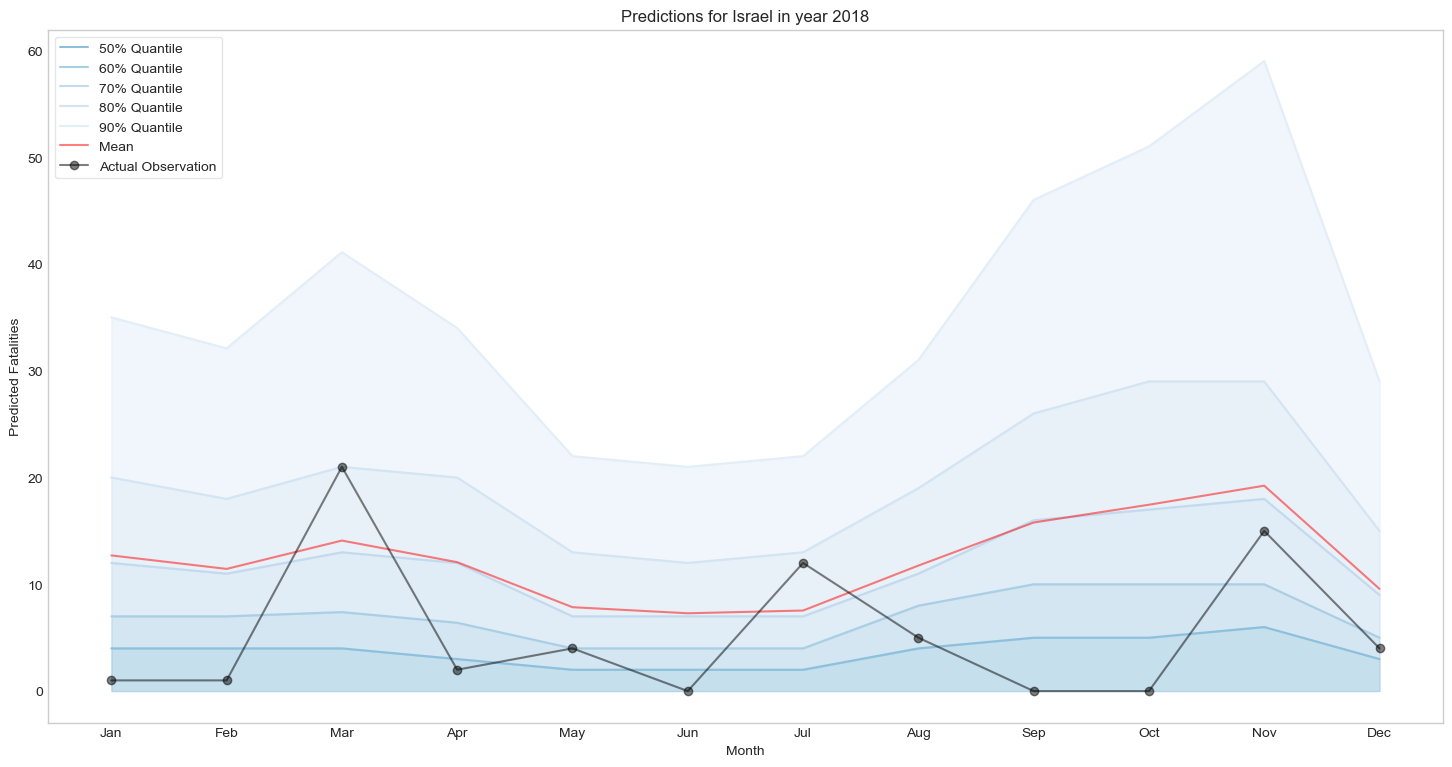

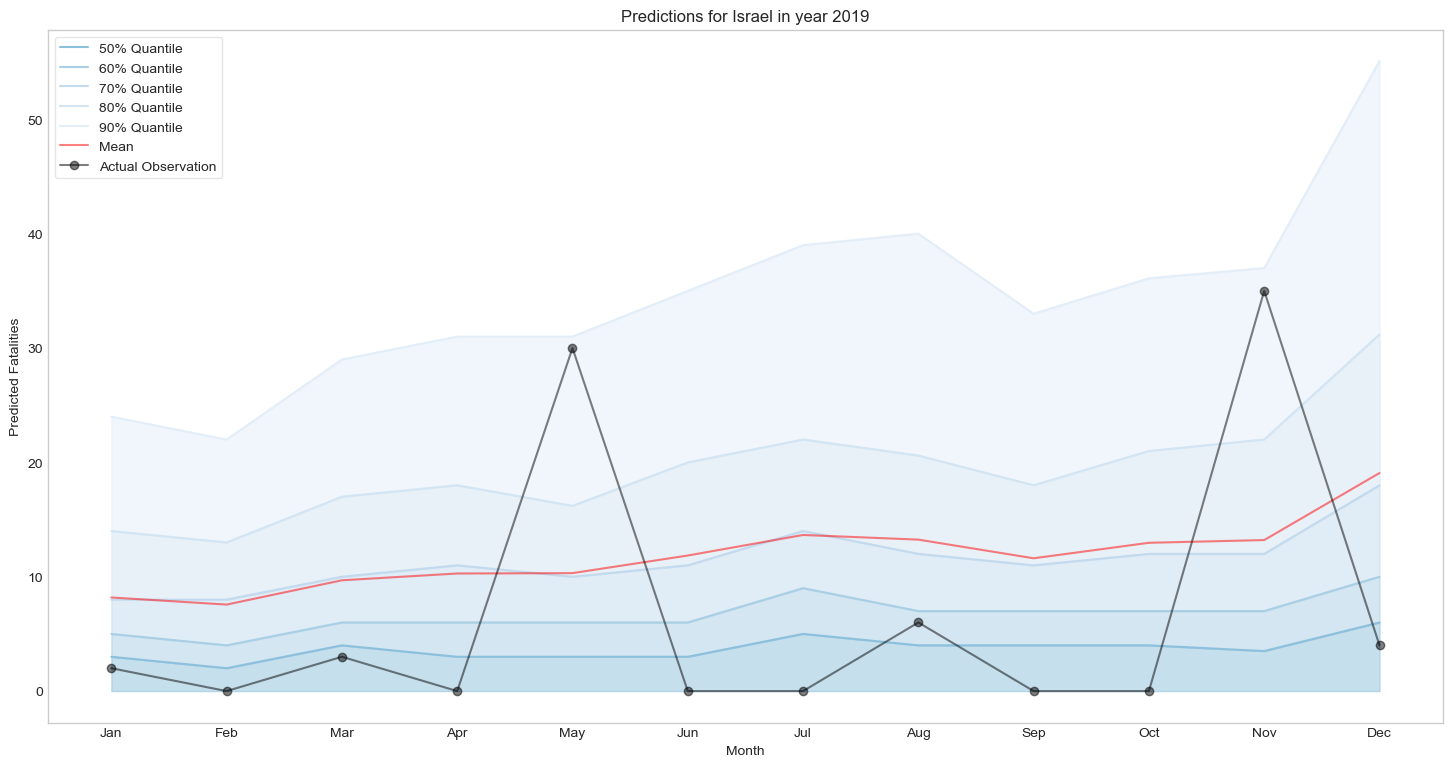

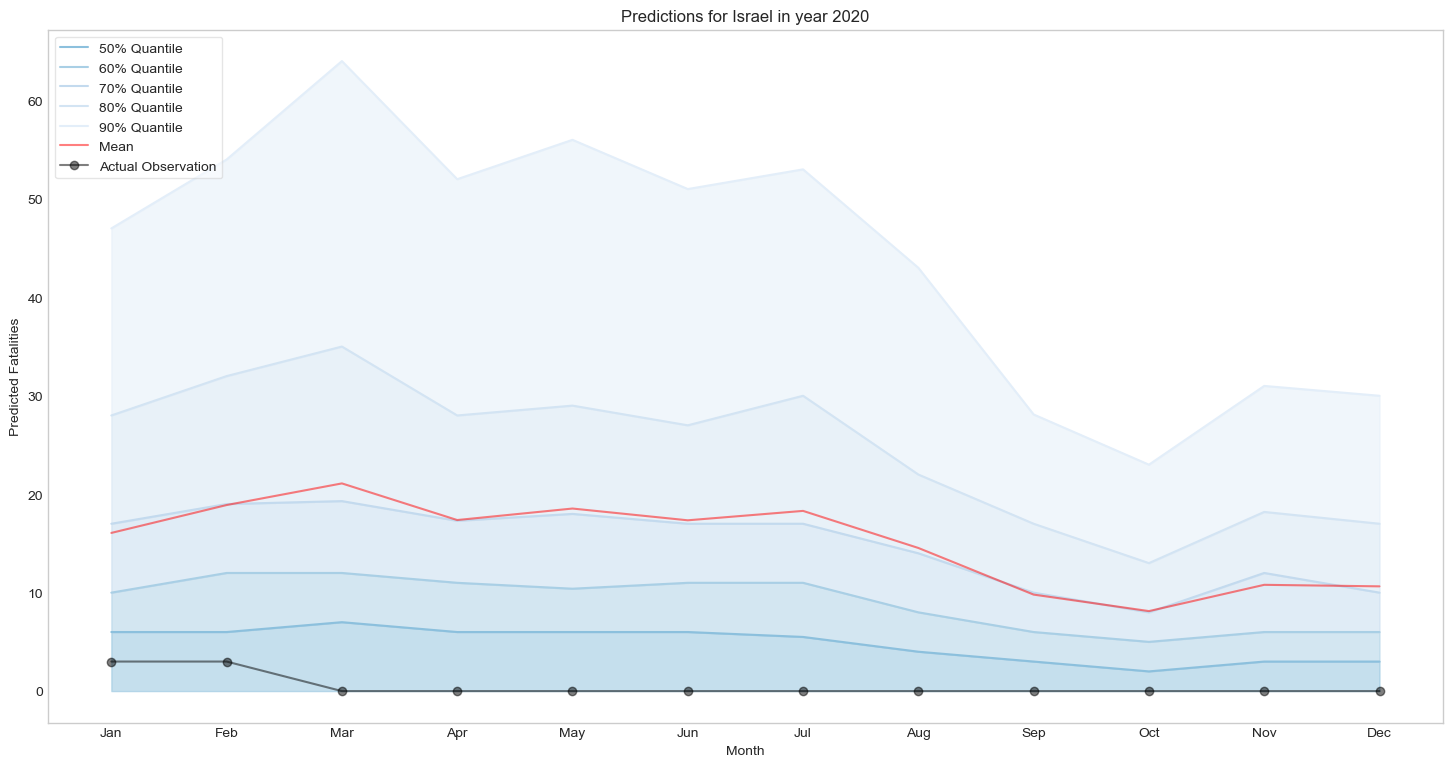

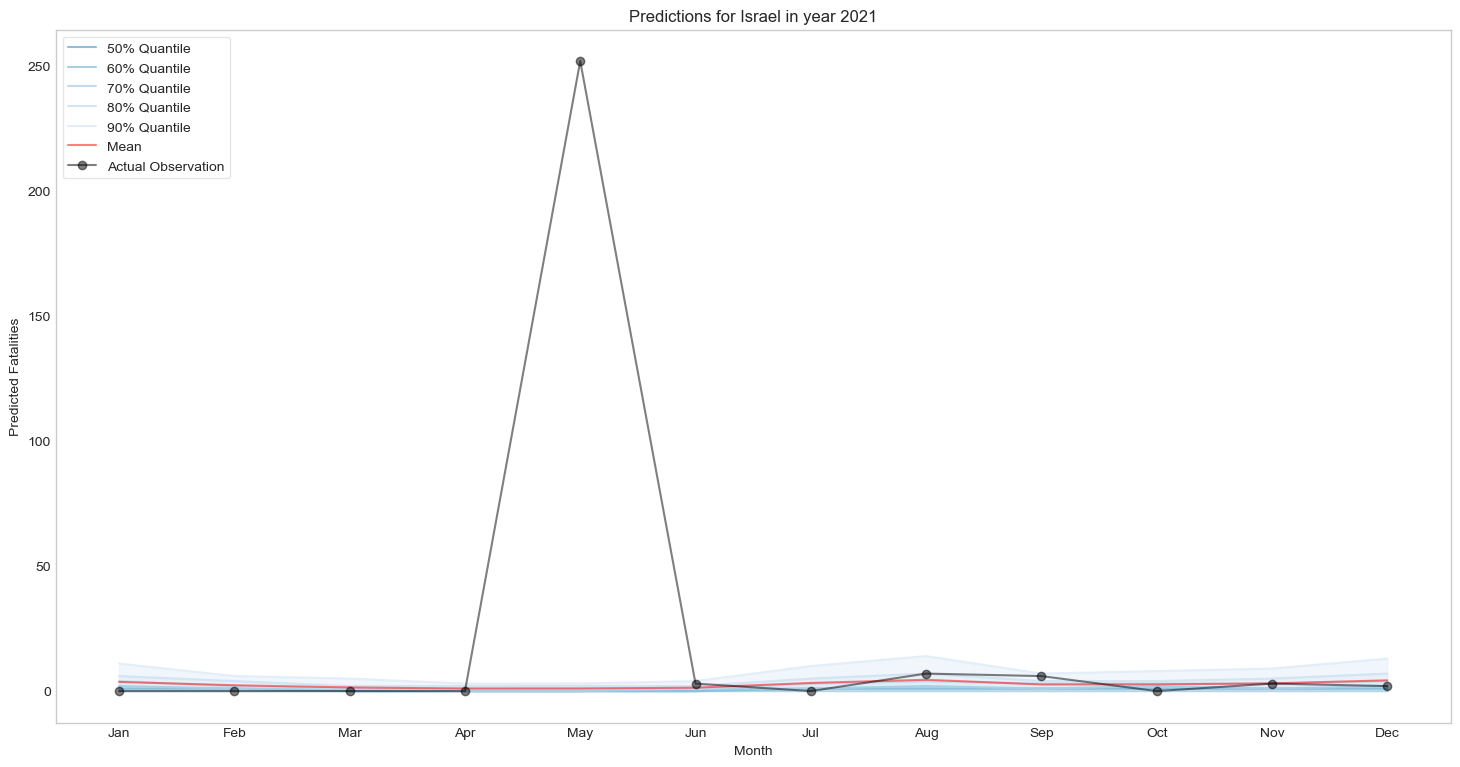

In [10]:
specific_country_name = ['Israel']
# specific_country_name = ['Saudi Arabia', 'Syria', 'Ethiopia', 'Cameroon', 'Yemen', 'Mali']
for year in [2018, 2019, 2020, 2021]:
    for country_name in specific_country_name:
        plot_country_data(pps, country_name, year, 1, year, 12)

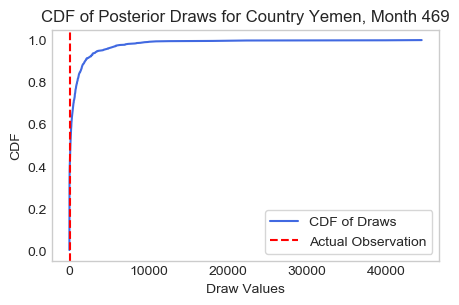

In [7]:
plot_cdf_with_observation(pps, 'Yemen', 469)

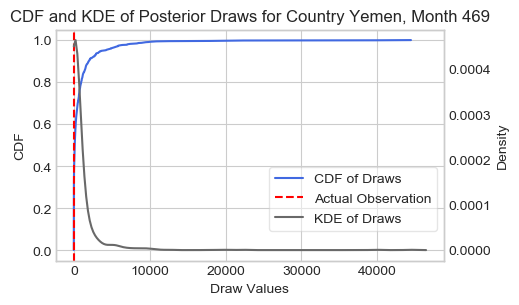

In [8]:
plot_cdf_and_kde_with_observation(pps, 'Yemen', 469)